<a href="https://colab.research.google.com/github/AbdulRehmanking/Augment-Reality/blob/main/Brain_Tumor_Segmentation_UNet_%2B_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240829%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240829T111552Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc2906991e0cf9e4e5772a9f39d540e62991a6447d4330cad2f1f59775cd0098bae4465d8ffddedbcb0c753a89be65175ea73638440a072c8ab2230981cf8f6ad36410c4ccbf9e87a5844fa05a61b911131522665587bec16a60e50064bf920bde491575a7d33faec35ecaf16333d70b870bd7878fdf0cd920b483b5576e7a8f8432375cc9eb52c9e0225962945e01883029634353daa02c9b526db3ad61ec07283113908738d352ac0d411f5811ba88e1ce0fb1c1151c62d5dbc26228e2f39b065b530d0b9f7553f460a7eee45636427bcf909df76bf517fe5553d9d83bc7bfc7a5343c52e78692bb8c0fa0a4ecd6d9e871c16a1e78afa6e1cbc65c5673c42c8'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 748584920 bytes downloaded
Downloaded and uncompressed: lgg-mri-segmentation
Data source import complete.


# Import Needed Modules

In [2]:
!pip install -q segmentation-models-pytorch

import os
import time
from glob import glob
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import albumentations as A
from scipy.ndimage.morphology import binary_dilation
import segmentation_models_pytorch as smp
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 25.5 MB/s eta 0:00:00


<ipython-input-2-22145fdabdf6>:14: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


#### Set device to cuda

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing

#### Get all files

In [4]:
files_dir = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/'
file_paths = glob(f'{files_dir}/*/*[0-9].tif')

#### Read csv file of data

In [5]:
csv_path = '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/data.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

#### Missing values handling

In [6]:
imputer = SimpleImputer(strategy="most_frequent")

df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,2.0,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,2.0,0.0
3,TCGA_CS_4944,2.0,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,2.0,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,TCGA_HT_8563,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,3.0,2.0,1.0,30.0,3.0,2.0,0.0
106,TCGA_HT_A5RC,2.0,4.0,2,2.0,2.0,3.0,2,1.0,2.0,1.0,1.0,2.0,1.0,70.0,3.0,2.0,1.0
107,TCGA_HT_A616,2.0,5.0,2,1.0,2.0,2.0,1,1.0,1.0,1.0,1.0,2.0,1.0,36.0,3.0,2.0,0.0
108,TCGA_HT_A61A,2.0,5.0,2,1.0,2.0,2.0,1,3.0,1.0,1.0,1.0,6.0,1.0,20.0,3.0,2.0,0.0


#### Function to get data

In [7]:
def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)

    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments

    return [patient_id, path, f'{path_no_ext}_mask{ext}']

In [8]:
# Show sample
get_file_row('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif')

['TCGA_DU_7010',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif']

#### Store the data into a dataframe

In [9]:
filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
filenames_df

,Patient,image_filename,mask_filename
0,TCGA_DU_7019,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
1,TCGA_DU_7019,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
2,TCGA_DU_7019,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3,TCGA_DU_7019,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
4,TCGA_DU_7019,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
...,...,...,...
3924,TCGA_DU_5854,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3925,TCGA_DU_5854,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3926,TCGA_DU_5854,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...
3927,TCGA_DU_5854,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...,/kaggle/input/lgg-mri-segmentation/lgg-mri-seg...


## Dataset Class

In [10]:
class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

In [11]:
df = pd.merge(df, filenames_df, on="Patient")

### Split data into train, valid, and test

In [12]:
train_df, test_df = train_test_split(df, test_size=0.3)
test_df, valid_df = train_test_split(test_df, test_size=0.5)

### Transforming
- Only applied channel dropout and random color changes, the model gave subpar results when confronted with rotations and flips.

In [13]:
transform = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

train_dataset = MriDataset(train_df, transform)
valid_dataset = MriDataset(valid_df)
test_dataset = MriDataset(test_df)

### DataLoaders

In [14]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

#### Show sample

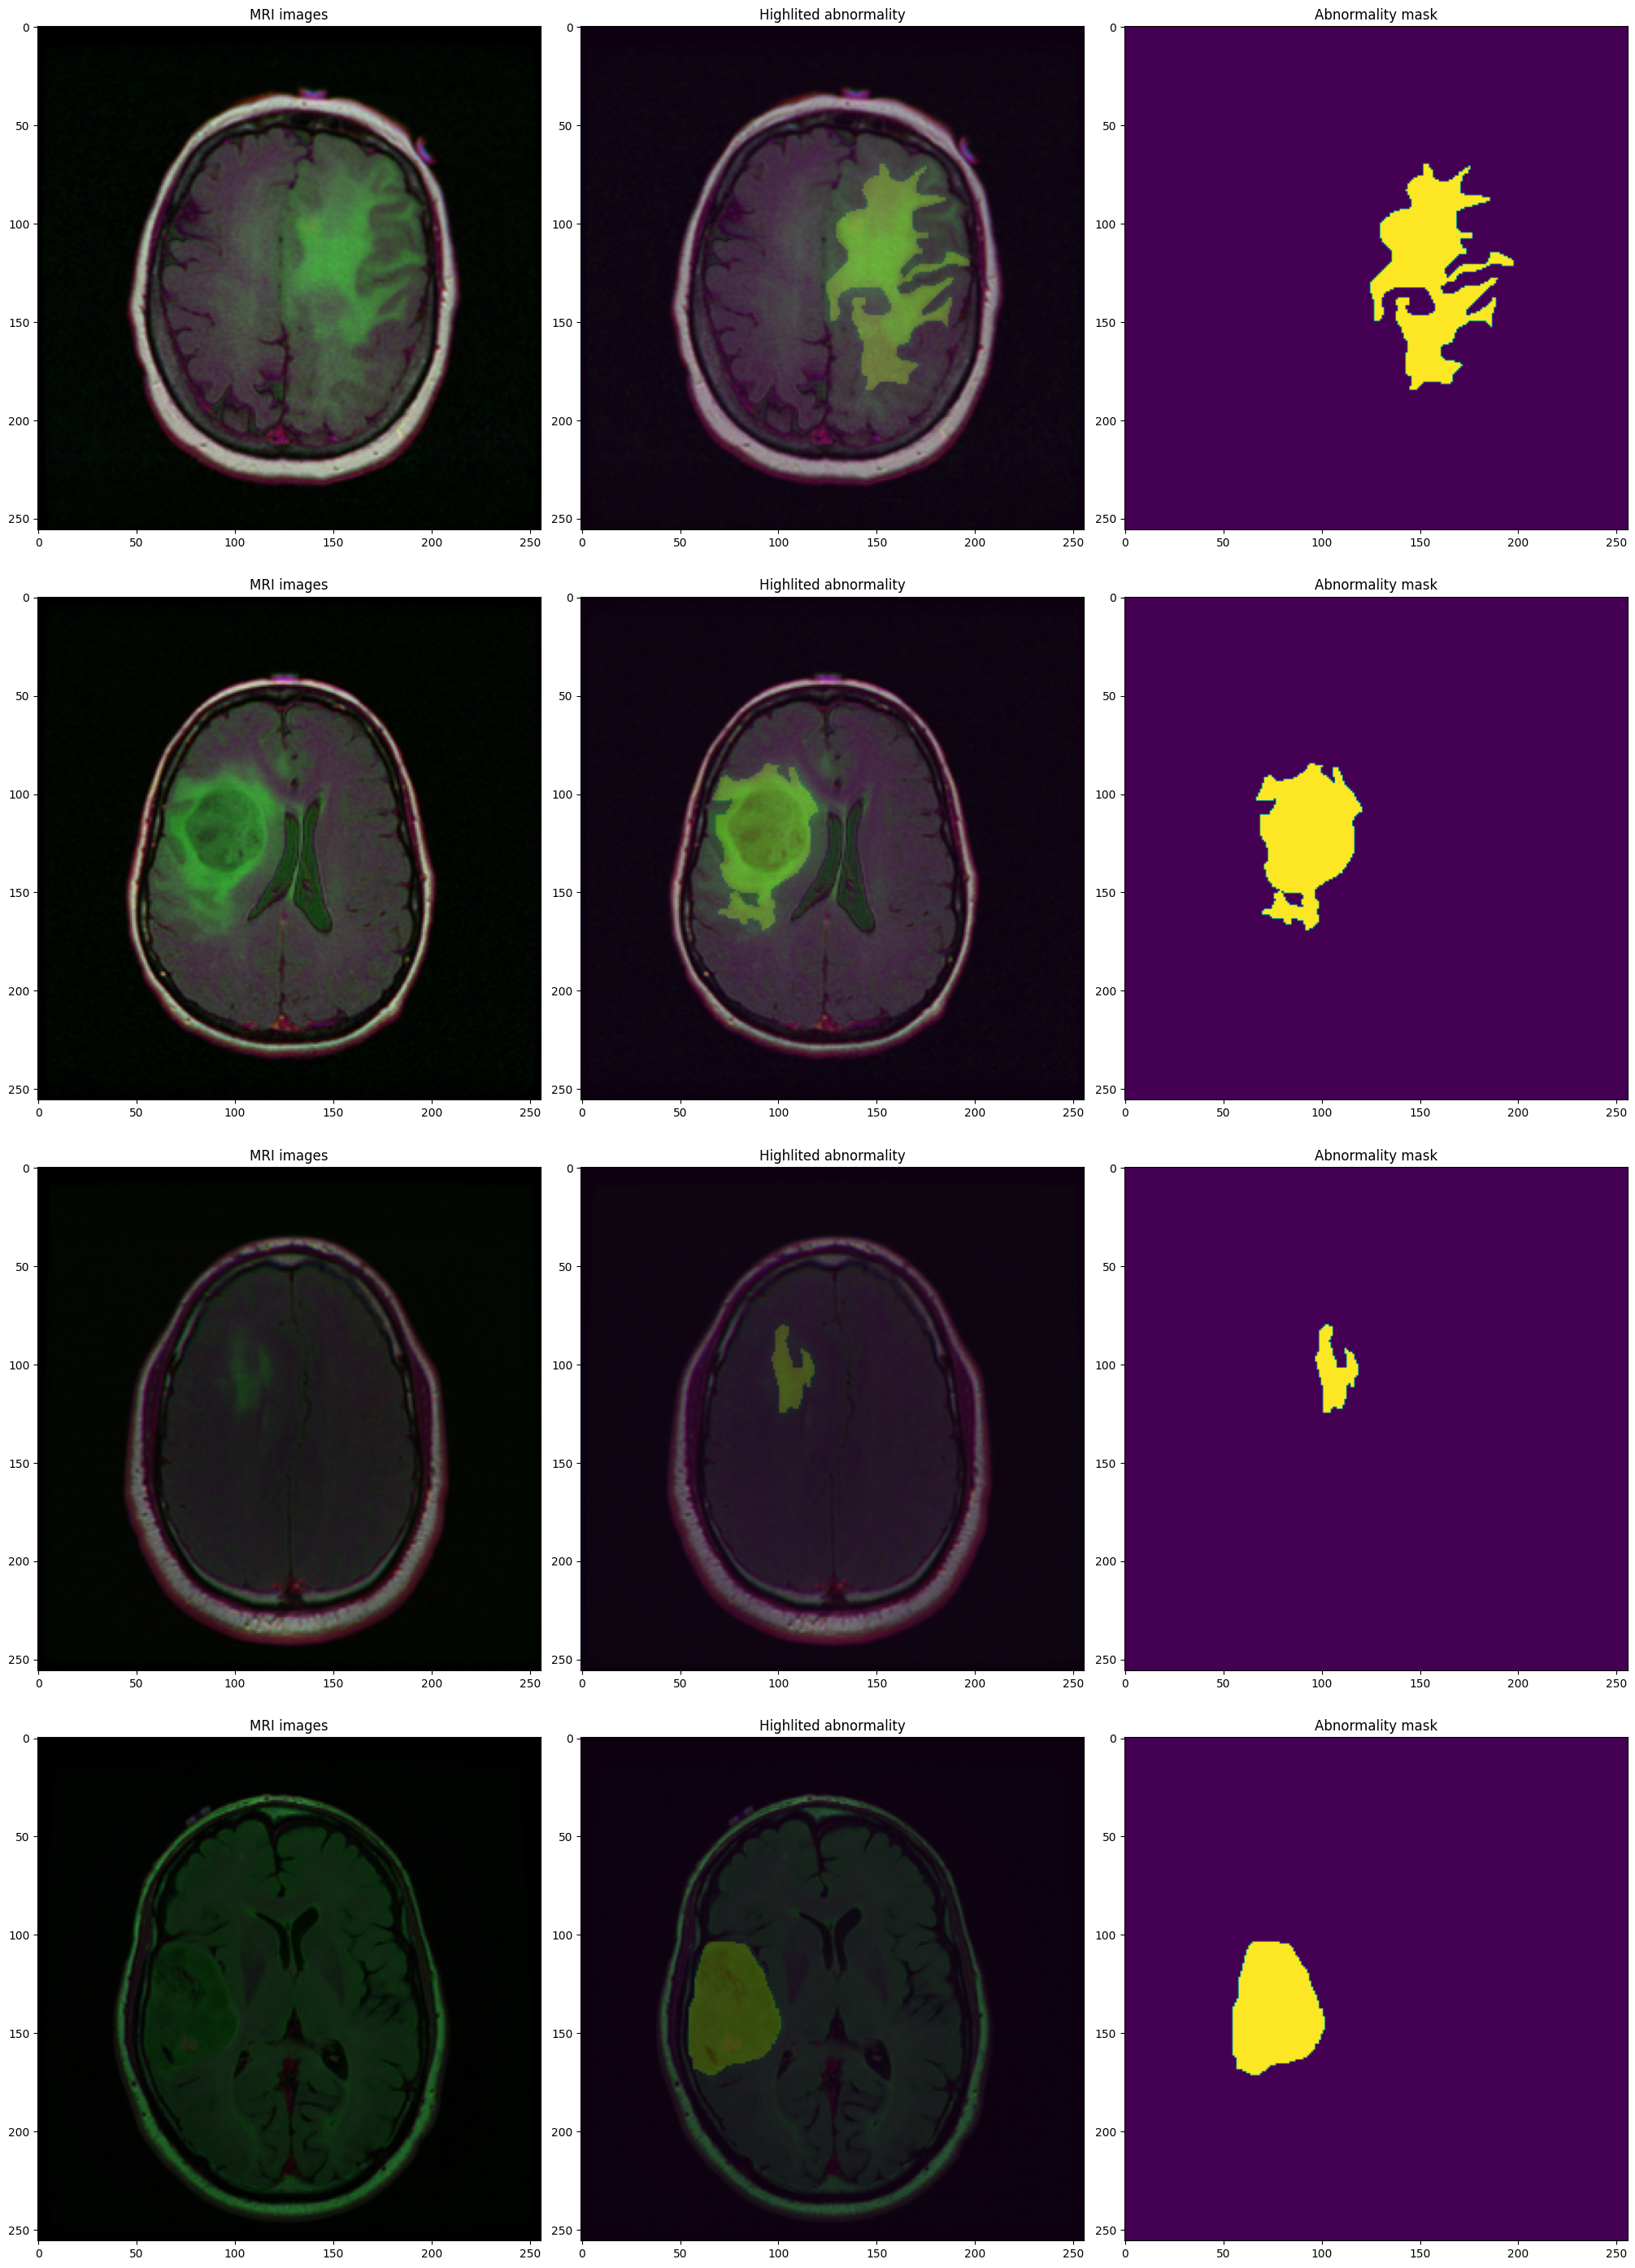

In [15]:
%matplotlib inline
n_examples = 4

fig, axs = plt.subplots(n_examples, 3, figsize=(20, n_examples*7), constrained_layout=True)
i = 0
for ax in axs:
    while True:
        image, mask = train_dataset.__getitem__(i, raw=True)
        i += 1
        if np.any(mask):
            ax[0].set_title("MRI images")
            ax[0].imshow(image)
            ax[1].set_title("Highlited abnormality")
            ax[1].imshow(image)
            ax[1].imshow(mask, alpha=0.2)
            ax[2].imshow(mask)
            ax[2].set_title("Abnormality mask")
            break





# Model Structure

In [16]:
import os

# Path to the directory where you want to save the model
model_dir = '/content/drive/My Drive/Colab Notebooks'

# Check if the directory exists, and create it if it does not
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print("Directory created:", model_dir)
else:
    print("Directory already exists:", model_dir)

# Now specify the path to save the model
path_to_save = os.path.join(model_dir, 'model.pth')


Directory created: /content/drive/My Drive/Colab Notebooks


In [17]:
# Assuming 'model' is your PyTorch model
torch.save(model.state_dict(), path_to_save)
print("Model saved successfully at:", path_to_save)


NameError: name 'model' is not defined

In [ ]:
# List files in the directory to verify
files_in_directory = os.listdir(model_dir)
print("Files in directory:", files_in_directory)

# Verify that 'model.pth' is in the list
assert 'model.pth' in files_in_directory, "Model file not found in the directory!"



In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

def define_model():
    return smp.Unet(
        encoder_name="efficientnet-b7",  # Ensure encoder is correctly specified
        encoder_weights=None,            # Ensure no pre-trained weights are loaded
        in_channels=3,                   # Match the in_channels with your training setup
        classes=1,                       # Match the number of output classes
        activation='sigmoid'             # Match the activation function
    )

def load_model(model_path):
    model = define_model()
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
    model.eval()
    return model

# Load your model (make sure model_path is correct)
model_path = '/content/drive/My Drive/Colab Notebooks/model.pth'
model = load_model(model_path)

def preprocess_image(image_path, desired_width=320, desired_height=320):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (desired_width, desired_height))
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.repeat(img, 3, axis=-1)
    img = np.transpose(img, (2, 0, 1))
    img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    return img

def predict(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        predicted_mask = torch.sigmoid(output)
        predicted_mask = (predicted_mask > 0.5).float()
    return predicted_mask

def display_results(original_image, predicted_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image.squeeze(0).permute(1, 2, 0).numpy(), cmap='gray')
    plt.title('Original MRI')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze().numpy(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

if __name__ == "__main__":
    model_path = '/content/drive/My Drive/Colab Notebooks/model.pth'
    image_path = '/bb.jpeg'

    model = load_model(model_path)
    image_tensor = preprocess_image(image_path, 320, 320)
    predicted_mask = predict(model, image_tensor)
    display_results(image_tensor, predicted_mask)


In [ ]:
import torch
import segmentation_models_pytorch as smp

def define_model():
    model = smp.Unet(
        encoder_name="efficientnet-b7",
        encoder_weights=None,  # Ensure this matches how you trained it, possibly 'imagenet'
        in_channels=3,
        classes=1,
        activation='sigmoid'
    )
    return model

def load_model(model_path):
    model = define_model()
    model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
    model.eval()
    return model

model_path = '/content/drive/My Drive/Colab Notebooks/model.pth'
model = load_model(model_path)


### Create EarlyStopping class

In [ ]:
def preprocess_image(image_path, desired_width=320, desired_height=320):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (desired_width, desired_height))
    img = img / 255.0  # Normalize the image to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    if img.shape[0] == 1:  # If grayscale, replicate to 3 channels if your model expects 3 channels
        img = np.repeat(img, 3, axis=0)
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    return img_tensor

image_path = '/bb.jpeg'
image_tensor = preprocess_image(image_path)


### Create metrics

In [ ]:
def predict(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)  # Apply sigmoid if your model doesn't include it
        predicted_mask = (output > 0.5).float()  # Threshold predictions to get binary mask
    return predicted_mask[0][0]  # Assuming your output is [N, C, H, W] format

predicted_mask = predict(model, image_tensor)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_results(original_image, predicted_mask):
    if original_image.ndim == 3 and original_image.shape[0] == 3:  # If the image has 3 channels and is in CxHxW format
        original_image = original_image.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')  # Now should work as the shape is appropriate
    plt.title('Original MRI')

    if predicted_mask.ndim == 3 and predicted_mask.shape[0] == 1:  # If the mask is single-channel but in CxHxW
        predicted_mask = predicted_mask.squeeze(0)  # Reduce C dimension if it's 1

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.show()


In [ ]:
image_path = '/bb.jpeg'
image_tensor = preprocess_image(image_path, 320, 320)
predicted_mask = predict(model, image_tensor)

# Now use the adjusted display function
display_results(image_tensor.squeeze().numpy(), predicted_mask.numpy())


In [ ]:
class EarlyStopping():
    """
    Stops training when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        """
        :param patience: number of epochs of non-decreasing loss before stopping
        :param min_delta: minimum difference between best and new loss that is considered
            an improvement
        :paran weights_path: Path to the file that should store the model's weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        """
        Loads weights of the best model.
        :param model: model to which the weigths should be loaded
        """
        return model.load_state_dict(torch.load(self.weights_path))


In [ ]:
def iou_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Intersection over Union for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()

    intersection = (predictions & labels).float().sum((1, 2))
    union = (predictions | labels).float().sum((1, 2))

    iou = (intersection + e) / (union + e)
    return iou

def dice_pytorch(predictions: torch.Tensor, labels: torch.Tensor, e: float = 1e-7):
    """Calculates Dice coefficient for a tensor of predictions"""
    predictions = torch.where(predictions > 0.5, 1, 0)
    labels = labels.byte()

    intersection = (predictions & labels).float().sum((1, 2))
    return ((2 * intersection) + e) / (predictions.float().sum((1, 2)) + labels.float().sum((1, 2)) + e)

In [ ]:
def BCE_dice(output, target, alpha=0.01):
    bce = torch.nn.functional.binary_cross_entropy(output, target)
    soft_dice = 1 - dice_pytorch(output, target).mean()
    return bce + alpha * soft_dice

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b7",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation='sigmoid',
)
model.to(device);

In [ ]:
def training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler):
    history = {'train_loss': [], 'val_loss': [], 'val_IoU': [], 'val_dice': []}
    early_stopping = EarlyStopping(patience=7)

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        running_loss = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            img, mask = data
            img, mask = img.to(device), mask.to(device)
            predictions = model(img)
            predictions = predictions.squeeze(1)
            loss = loss_fn(predictions, mask)
            running_loss += loss.item() * img.size(0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            running_IoU = 0
            running_dice = 0
            running_valid_loss = 0
            for i, data in enumerate(valid_loader):
                img, mask = data
                img, mask = img.to(device), mask.to(device)
                predictions = model(img)
                predictions = predictions.squeeze(1)
                running_dice += dice_pytorch(predictions, mask).sum().item()
                running_IoU += iou_pytorch(predictions, mask).sum().item()
                loss = loss_fn(predictions, mask)
                running_valid_loss += loss.item() * img.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        val_loss = running_valid_loss / len(valid_loader.dataset)
        val_dice = running_dice / len(valid_loader.dataset)
        val_IoU = running_IoU / len(valid_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_IoU'].append(val_IoU)
        history['val_dice'].append(val_dice)
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss} | Validation loss: {val_loss} | Validation Mean IoU: {val_IoU} '
         f'| Validation Dice coefficient: {val_dice}')

        lr_scheduler.step(val_loss)
        if early_stopping(val_loss, model):
            early_stopping.load_weights(model)
            break
    model.eval()
    return history

In [ ]:
loss_fn = BCE_dice
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 60
lr_scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=2,factor=0.2)

history = training_loop(epochs, model, train_loader, valid_loader, optimizer, loss_fn, lr_scheduler)